# Loading Packages

In [583]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat

In [584]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [585]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

# Loading Data (with scaling)

In [586]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [587]:
shift = 1
model_name = 's_monkey_1_v2'
set_values = [5,6]
labels = ['s_1','s_2','s_3','s_4']
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

In [588]:
#with scaling
df_human = pd.read_csv("data_human_filtered.csv")
df_human = df_human.drop(columns='id')
file = "data_model_v2.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
#df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)
#df = df[columns_to_keep]
# Step 1: Separate 'id' and 'trial' columns from the rest of the data
data_to_scale = df.drop(columns=['id', 'trial'])

# Step 2: Apply MinMaxScaler to the remaining columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)

# Step 3: Merge 'id' and 'trial' columns with the scaled data
scaled_df[['id', 'trial']] = df[['id', 'trial']]

# Step 4: create variable t-1
# List of columns to shift
columns_to_shift = ['s_1', 's_2', 's_3','s_4']  # List all column names here

# Create shifted columns for each column in the list
for col in columns_to_shift:
    new_col_name = col + '_minus_' + str(shift)
    scaled_df[new_col_name] = scaled_df[col].shift(shift)
    scaled_df[new_col_name] = scaled_df[new_col_name].fillna(1)  # Fill NaN in the first row with 1
    scaled_df[new_col_name] = scaled_df[new_col_name].astype(int)

#desired_column_order = [col for col in scaled_df.columns if col not in columns_to_shift] + columns_to_shift
#scaled_df = scaled_df[desired_column_order]
#selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
#scaled_df = scaled_df[selected_columns]
# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = scaled_df[-scaled_df['trial'].isin(set_values)].drop(columns=['id', 'trial'])
test_set = scaled_df[scaled_df['trial']==set_values[0]].drop(columns=['id', 'trial'])
val_set = scaled_df[scaled_df['trial']==set_values[1]].drop(columns=['id', 'trial'])
full_set = scaled_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_test, y_test = test_set.drop(columns=labels), test_set[labels]
X_val, y_val = val_set.drop(columns=labels), val_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]

#X_train, y_train = train_set.iloc[:,:-4], train_set.iloc[:,-4:]
#X_test, y_test = test_set.iloc[:,:-4], test_set.iloc[:,-4:]
#X_val, y_val = val_set.iloc[:,:-4], val_set.iloc[:,-4:]
#X, y = full_set.iloc[:,:-4], full_set.iloc[:,-4:]

# Create custom datasets for training, validation, and testing
full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))
test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

# Create a DataLoader
#batch_size = 5561#67  # Set your desired batch size
#shuffle = False  # Set to False to preserve the order of your data
fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)

# Model Architecture

In [589]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2, bidirectional=False):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)
        #Xavier initialization for GRU weights
        #for name, param in self.gru.named_parameters():
        #    if 'weight' in name:
        #        init.xavier_uniform_(param.data)
        #    elif 'bias' in name:
        #        init.constant_(param.data, 0.0)
                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sotfplus = nn.Softplus()
        self.relu = nn.ReLU()

        
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.sotfplus(out[:,-1]))
        #out = self.fc(self.relu(out[:,-1]))
        out = F.softmax(out, dim=1)
        return out, h
    
    #def init_hidden(self, batch_size):
        #weight = next(self.parameters()).data
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        #return hidden
    def init_hidden(self, batch_size):
        if batch_size > 1:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        else:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, self.hidden_dim).zero_().to(device)
        return hidden

In [590]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim) for _ in range(self.num_layers)]
        
        hidden_states = []
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            new_hidden_states = []
            for layer_idx, gru_cell in enumerate(self.gru_cells):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                new_hidden_states.append(h[layer_idx])
                input_t = h[layer_idx]  # Update input_t with the new hidden state for the next layer
            hidden_states.append(new_hidden_states)
        
        last_hidden_states = [layer_states[-1] for layer_states in hidden_states]
        # Apply BatchNorm to the last hidden state
        last_hidden_states[-1] = self.batch_norm(last_hidden_states[-1])
        #all_hidden_states = torch.cat(hidden_states, dim=1)  # Stack all hidden states across time steps
        
        
        out = self.fc(self.softplus(last_hidden_states[-1]))
        #out = self.fc(self.softplus(all_hidden_states[:, -1]))  # Use the last hidden state for prediction
        #probs = torch.sigmoid(out)  # Apply sigmoid activation to get probabilities
        #preds = torch.round(probs)  # Convert probabilities to binary predictions
        #out = F.sigmoid(out, dim=1)
        
        return out, last_hidden_states 
    
    
    
    #def init_hidden(self, batch_size):
     #   return nn.Parameter(torch.zeros([batch_size, self.gru_cells[0].hidden_size]))

# Training functions

In [591]:
def accuracy(correct, total):
    return float(correct)/total

In [592]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        
        out, last_hidden_states = model(x)
        y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(y_prob.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        #hidden_states.append(hidden)
        
        y_pred = torch.round(y_prob)
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs 

In [593]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            #hidden_states.append(hidden)
            y_pred = torch.sigmoid(out)
            predicted_probs.append(y_pred.cpu().detach().numpy())
            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs

In [594]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    #train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        #train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            #val_hidden_states.extend(val_hidden)
        
        #if isinstance(scheduler, ReduceLROnPlateau):
        #    scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 50 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final
    else: 
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final

# Testing

In [595]:
X_train.shape

(5944, 46)

In [596]:
X_train.shape[1]

46

In [597]:

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =500
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [598]:
train_losses, train_accs, val_losses, val_accs, train_predicted, val_predicted, train_probs, val_probs= run_training(
    train_dataloader, val_dataloader=val_dataloader, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)

Epoch 0, train loss: 1.1030354499816895, train acc: 0.41613391655450876, val loss: 0.9479348659515381, val acc: 0.4894179894179894
Epoch 50, train loss: 0.04483161121606827, train acc: 0.9976867429340511, val loss: 0.06512130796909332, val acc: 0.9982363315696648
Epoch 100, train loss: 0.017072446644306183, train acc: 0.9984438088829072, val loss: 0.016153665259480476, val acc: 0.9986772486772487
Epoch 150, train loss: 0.012911196798086166, train acc: 0.998485868102288, val loss: 0.012462827377021313, val acc: 0.9986772486772487
Epoch 200, train loss: 0.011294792406260967, train acc: 0.998485868102288, val loss: 0.011048141866922379, val acc: 0.9986772486772487
Epoch 250, train loss: 0.01043099444359541, train acc: 0.998485868102288, val loss: 0.01032087579369545, val acc: 0.9986772486772487
Epoch 300, train loss: 0.009891212917864323, train acc: 0.998485868102288, val loss: 0.009885950945317745, val acc: 0.9986772486772487
Epoch 350, train loss: 0.00952280405908823, train acc: 0.99848

In [599]:

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)
os.makedirs(folder_path, exist_ok=True)
# Assuming your model is named 'model'
state_dict = model.state_dict()

# Specify the folder path and the model filename
folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
model_filename = model_name + '.pth'  

# Combine the folder path and model filename
full_model = os.path.join(folder_path, model_filename)

# Save the model to the specified folder
torch.save(state_dict, full_model)

In [600]:
# Load the saved weights into the model
#torch.save(model.state_dict(), 'model_weights.pth')
#zmodel = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load(full_model))
model.eval()  # Set the model in evaluation mode


GRUCellNet(
  (gru): GRUCell(46, 34)
  (fc): Linear(in_features=34, out_features=4, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (relu): ReLU()
  (gru_cells): ModuleList(
    (0): GRUCell(46, 34)
  )
  (batch_norm): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Predictions

In [601]:
model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in test_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns
print(all_probs_df)

          s_1       s_2       s_3       s_4
0    0.919003  0.864155  0.849839  0.999999
1    0.999848  0.999815  0.999650  0.999982
2    0.999809  0.999790  0.999658  0.999974
3    0.999761  0.999738  0.999674  0.999961
4    0.999711  0.999694  0.999655  0.999940
..        ...       ...       ...       ...
436  0.002226  0.014646  0.994575  0.001721
437  0.002142  0.014757  0.994344  0.001782
438  0.002100  0.015200  0.994339  0.001851
439  0.002015  0.015562  0.993962  0.001893
440  0.001961  0.015946  0.993654  0.001986

[441 rows x 4 columns]


In [602]:
# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

Accuracy for each output state:
0.9982993197278912


model_name

In [603]:
all_probs_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,431,432,433,434,435,436,437,438,439,440
s_1,0.919003,0.999848,0.999809,0.999761,0.999711,0.999666,0.999605,0.999589,0.999880,0.999829,...,0.002689,0.002676,0.002654,0.002338,0.002270,0.002226,0.002142,0.002100,0.002015,0.001961
s_2,0.864155,0.999815,0.999790,0.999738,0.999694,0.999647,0.999475,0.999415,0.999579,0.999427,...,0.014159,0.013752,0.014377,0.013436,0.013596,0.014646,0.014757,0.015200,0.015562,0.015946
s_3,0.849839,0.999650,0.999658,0.999674,0.999655,0.999693,0.999675,0.999580,0.999480,0.999492,...,0.995571,0.995396,0.995771,0.994864,0.994665,0.994575,0.994344,0.994339,0.993962,0.993654
s_4,0.999999,0.999982,0.999974,0.999961,0.999940,0.999928,0.999853,0.999825,0.998182,0.997636,...,0.001552,0.001501,0.001576,0.001622,0.001634,0.001721,0.001782,0.001851,0.001893,0.001986


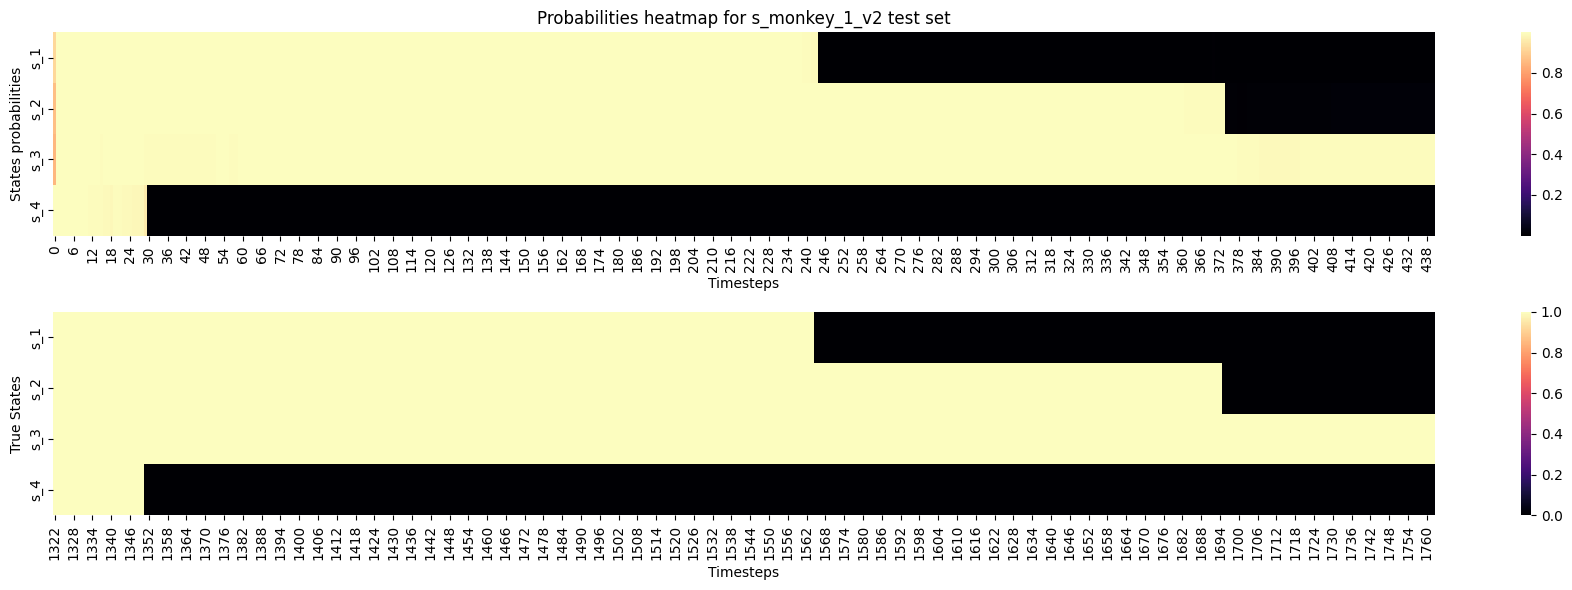

<Figure size 640x480 with 0 Axes>

In [604]:
plt.figure(figsize=(18, 6)) 
# Add labels and a title


# Show the plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
plt.title("Probabilities heatmap for "+model_name+' test set')  # Replace with your title
sns.heatmap(all_probs_df.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("States probabilities")  # Replace with your y-axis label

plt.subplot(2, 1, 2)
sns.heatmap(y_test.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("True States")  # Replace with your y-axis label


# Define the folder where you want to save the plot
save_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots'

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)

# Specify the full file path including the folder to save the plot
save_path = os.path.join(save_folder,model_name+'_test.png')

# Save the plot to the specified folder and file
plt.savefig(save_path, dpi=100, bbox_inches='tight')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

plt.savefig(model_name+'_test.png')

# plot on val data

In [605]:
model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in val_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns
print(all_probs_df)

          s_1       s_2       s_3       s_4
0    0.989547  0.959933  1.000000  0.985353
1    0.999902  0.999932  0.999972  0.999995
2    0.999928  0.999889  0.999986  0.999987
3    0.999909  0.999876  0.999982  0.999982
4    0.999880  0.999898  0.999953  0.999974
..        ...       ...       ...       ...
562  0.002012  0.983680  0.006068  0.001148
563  0.002180  0.982101  0.006089  0.001243
564  0.002412  0.981197  0.005888  0.001309
565  0.002476  0.981221  0.005846  0.001327
566  0.002446  0.981497  0.005879  0.001340

[567 rows x 4 columns]


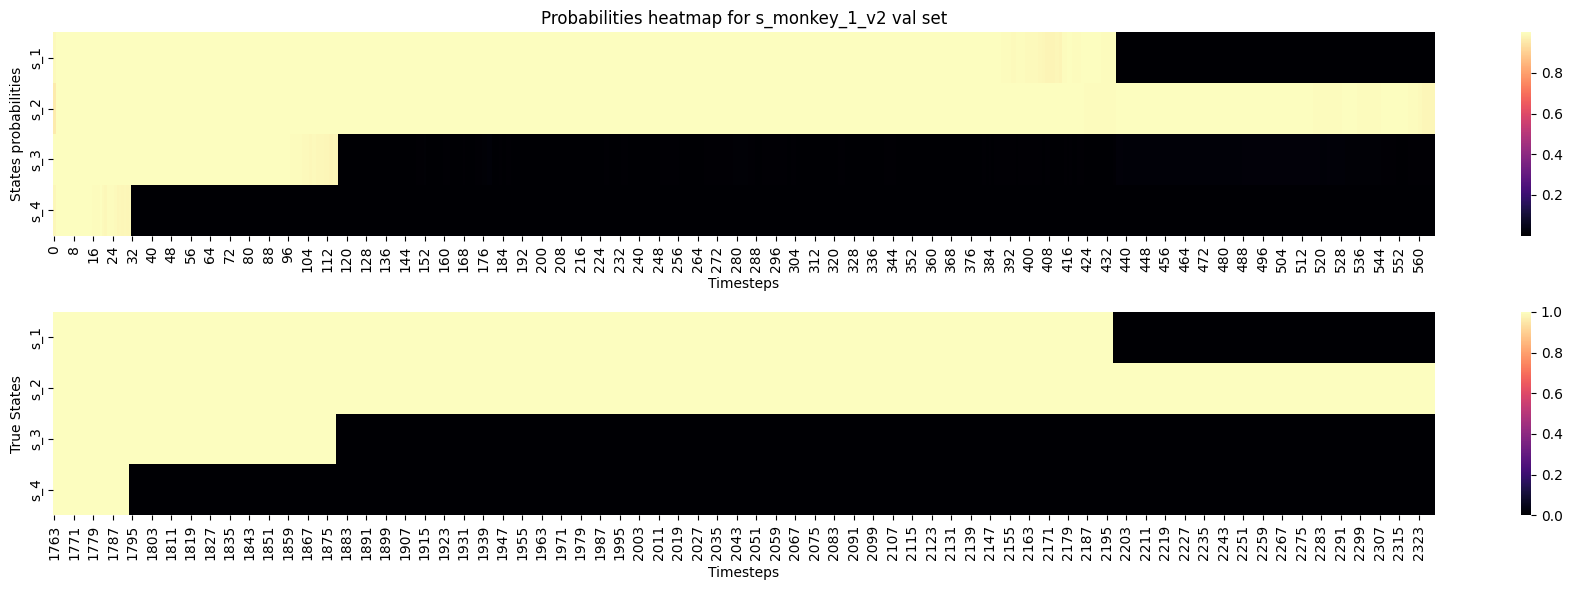

In [606]:
plt.figure(figsize=(18, 6)) 
# Add labels and a title


# Show the plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
plt.title("Probabilities heatmap for "+model_name+' val set')  # Replace with your title
sns.heatmap(all_probs_df.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("States probabilities")  # Replace with your y-axis label

plt.subplot(2, 1, 2)
sns.heatmap(y_val.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("True States")  # Replace with your y-axis label


# Define the folder where you want to save the plot
save_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots'

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)

# Specify the full file path including the folder to save the plot
save_path = os.path.join(save_folder,model_name+'_val.png')

# Save the plot to the specified folder and file
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#plt.savefig(model_name+'_test.png')

In [607]:
X_val

,nose_x,nose_y,nose_z,headTop_x,headTop_y,headTop_z,neck_x,neck_y,neck_z,tailBase_x,...,rWrist_x,rWrist_y,rWrist_z,rHip_x,rHip_y,rHip_z,s_1_minus_1,s_2_minus_1,s_3_minus_1,s_4_minus_1
1763,0.991328,0.308832,0.082882,0.989226,0.304959,0.070220,0.654715,0.640529,0.337844,0.513339,...,0.944081,0.573259,0.067031,0.907743,0.286042,0.562597,0,0,1,0
1764,0.989729,0.304431,0.102329,0.986152,0.301338,0.089087,0.654715,0.640529,0.337844,0.513339,...,0.942922,0.569899,0.073707,0.908150,0.289489,0.566919,1,1,1,1
1765,0.988134,0.300754,0.119426,0.985116,0.296590,0.110174,0.654715,0.640529,0.337844,0.513339,...,0.941359,0.559624,0.095856,0.910991,0.285632,0.580057,1,1,1,1
1766,0.984582,0.297871,0.136983,0.980818,0.292828,0.121548,0.654715,0.640529,0.337844,0.513339,...,0.935415,0.551544,0.111816,0.914221,0.277809,0.584107,1,1,1,1
1767,0.981412,0.293418,0.155468,0.977521,0.285940,0.145312,0.654715,0.640529,0.337844,0.513339,...,0.930749,0.548212,0.128941,0.917392,0.279137,0.589014,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,0.347800,0.106924,0.968760,0.347103,0.102038,0.973093,0.336988,0.121625,0.977366,0.248700,...,0.385180,0.258463,0.950216,0.246530,0.574420,0.711936,0,1,0,0
2326,0.349005,0.099321,0.966419,0.348476,0.095415,0.970188,0.340226,0.115577,0.977673,0.253859,...,0.385565,0.258385,0.947077,0.250495,0.568477,0.714169,0,1,0,0
2327,0.349306,0.092970,0.957378,0.348954,0.090208,0.959875,0.342792,0.111351,0.976126,0.261212,...,0.379884,0.263616,0.954345,0.260900,0.558096,0.706176,0,1,0,0
2328,0.352058,0.086259,0.943734,0.351513,0.084906,0.945318,0.346386,0.107146,0.971844,0.265995,...,0.378258,0.262125,0.961465,0.266679,0.548397,0.707712,0,1,0,0


In [608]:
#shift = 10
#model_name = 's_minus_10'

# Specify the folder path and the model filename
folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
model_filename = model_name + '.pth'  

# Combine the folder path and model filename
full_model = os.path.join(folder_path, model_filename)

model.load_state_dict(torch.load(full_model))

model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in test_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns



# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_preds.numpy(), columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

Accuracy for each output state:
0.9982993197278912


In [609]:
print(all_preds)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])


In [610]:
print(y_test)

      s_1  s_2  s_3  s_4
1322  1.0  1.0  1.0  1.0
1323  1.0  1.0  1.0  1.0
1324  1.0  1.0  1.0  1.0
1325  1.0  1.0  1.0  1.0
1326  1.0  1.0  1.0  1.0
...   ...  ...  ...  ...
1758  0.0  0.0  1.0  0.0
1759  0.0  0.0  1.0  0.0
1760  0.0  0.0  1.0  0.0
1761  0.0  0.0  1.0  0.0
1762  0.0  0.0  1.0  0.0

[441 rows x 4 columns]
